In [91]:
%load_ext autoreload
%autoreload 2
from alphatoe import plot, game, evals, interpretability
from alphatoe.interpretability import numpy
from alphatoe import fancy_plots as fp
import torch as t
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)
#define sequence of moves
seq_fwd = t.tensor([[10, 0, 1, 2, 3, 4, 5, 7, 8, 6]])
pos_emb = model.pos_embed(seq_fwd, 0)[0] #positional embedding (10, 128)
#normalize all positional embeddings
pos_emb_normed = pos_emb/t.norm(pos_emb, dim=-1, keepdim=True)
W_pos = model.W_pos #(10, 128)
W_K = model.W_K[0, 1] # Head index 1 (128, 16)
W_Q = model.W_Q[0, 1] # Head index 1 (128, 16)
K = pos_emb@W_K #(10, 16)
Q = pos_emb@W_Q #(10, 16)
vmin = -.25
vmax = .25

dotty = Q@K.T
dotty = dotty/t.sqrt(t.tensor(16))
softmax = t.softmax(dotty, axis=-1)
softmax = numpy(softmax)

# Create mask for upper triangle, keeping the diagonal
mask = np.triu(np.ones_like(softmax), k=1)
softmax_mask = softmax * (1 - mask)


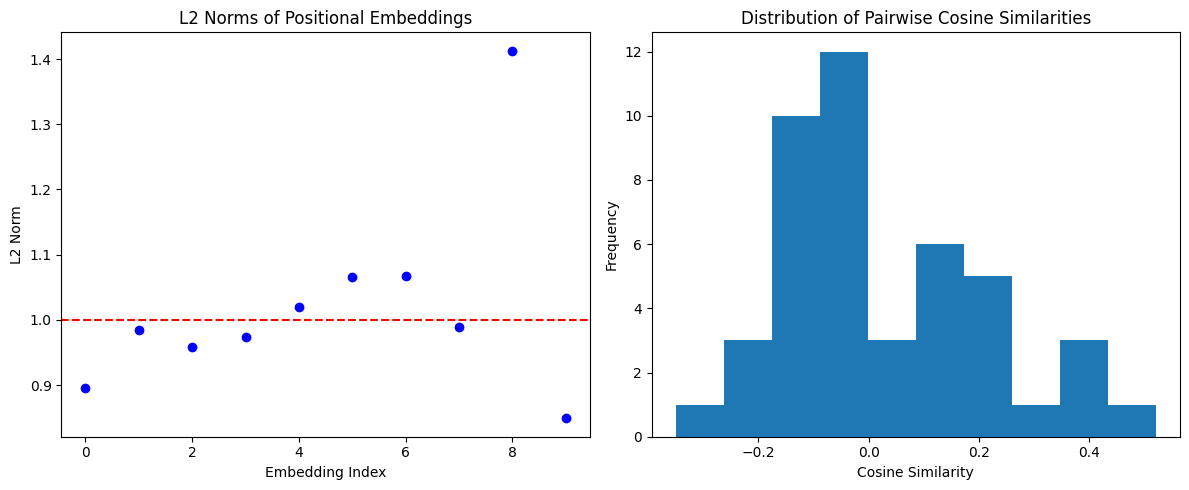

In [93]:
embeddings = numpy(pos_emb)

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

norms = [np.linalg.norm(emb) for emb in embeddings]

n_embeddings = len(embeddings)
cosine_sims = []
for i in range(n_embeddings):
    for j in range(i+1, n_embeddings):
        cosine_sims.append(cosine_similarity(embeddings[i], embeddings[j]))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(norms)), norms, 'bo')
plt.axhline(y=1, color='r', linestyle='--')
plt.title('L2 Norms of Positional Embeddings')
plt.xlabel('Embedding Index')
plt.ylabel('L2 Norm')

plt.subplot(1, 2, 2)
plt.hist(cosine_sims)
plt.title('Distribution of Pairwise Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

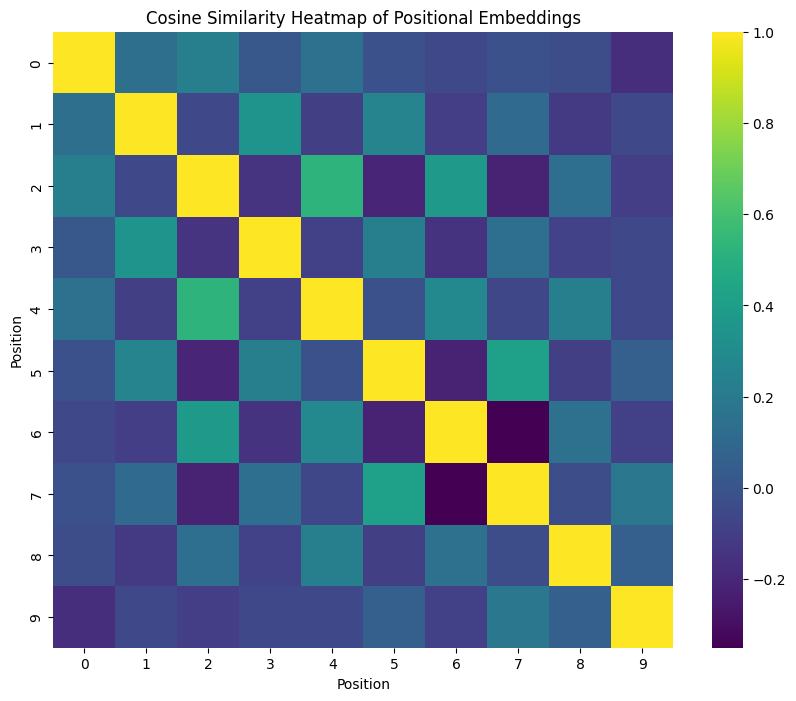

In [94]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

n_embeddings = len(embeddings)
similarity_matrix = np.zeros((n_embeddings, n_embeddings))

for i in range(n_embeddings):
    for j in range(n_embeddings):
        similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title('Cosine Similarity Heatmap of Positional Embeddings')
plt.xlabel('Position')
plt.ylabel('Position')
plt.show()

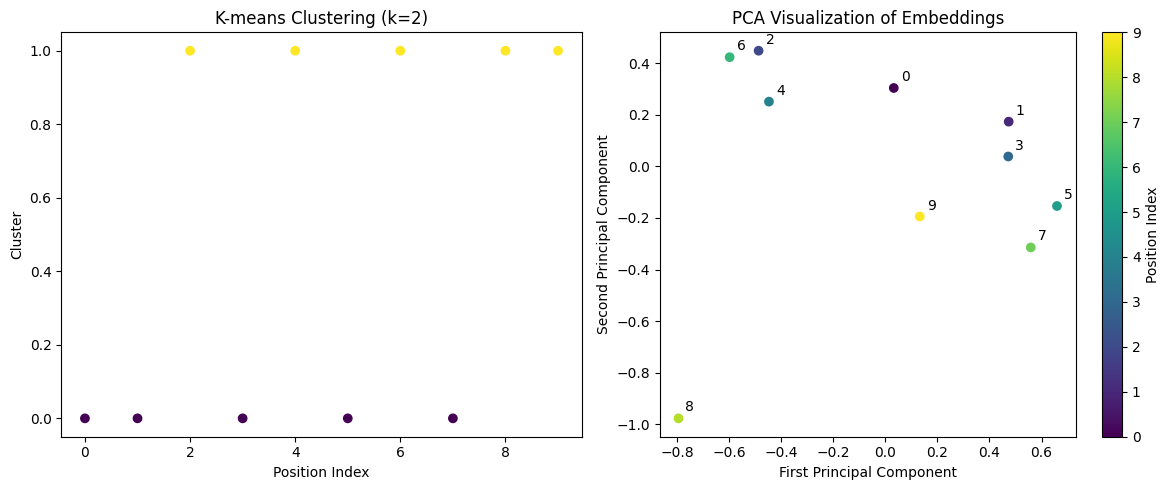

Clustering accuracy: 0.80


In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming 'embeddings' is your numpy array of shape (n_positions, 128)

# K-means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(12, 5))

# K-means result
plt.subplot(1, 2, 1)
plt.scatter(range(len(embeddings)), cluster_labels, c=cluster_labels, cmap='viridis')
plt.title('K-means Clustering (k=2)')
plt.xlabel('Position Index')
plt.ylabel('Cluster')

# PCA visualization
plt.subplot(1, 2, 2)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(len(embeddings)), cmap='viridis')
plt.title('PCA Visualization of Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Position Index')

# Annotate points with their position index
for i, (x, y) in enumerate(embeddings_2d):
    plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Print clustering accuracy
odd_cluster = cluster_labels[1] # cluster label for the first odd position
accuracy = np.mean((cluster_labels == odd_cluster) == (np.arange(len(embeddings)) % 2 == 1))
print(f"Clustering accuracy: {accuracy:.2f}")

/Users/omarayyub/p/Alphatoe/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


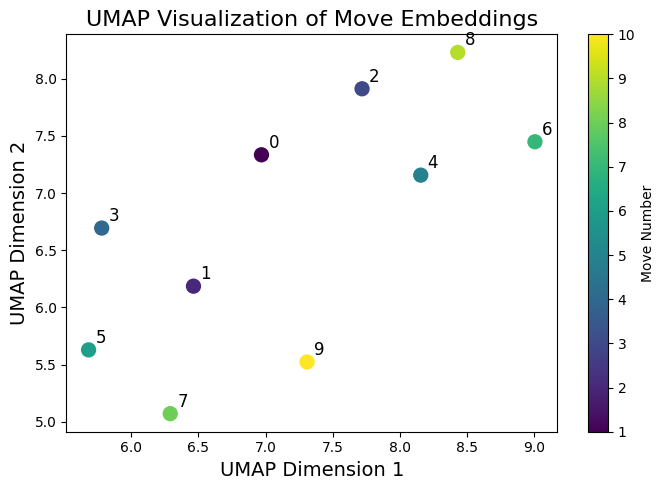

In [96]:
from umap import UMAP

reducer = UMAP(n_neighbors=5, min_dist=0.3, n_components=2, random_state=42)

embeddings_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(7, 5))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=range(1, len(embeddings)+1), cmap='viridis', s=100)
plt.colorbar(scatter, label='Move Number')

for i, (x, y) in enumerate(embeddings_2d, 1):
    plt.annotate(str(i-1), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.title('UMAP Visualization of Move Embeddings', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.tight_layout()
plt.show()

Average odd-odd similarity: 0.16179947555065155
Average even-even similarity: 0.1975267082452774
Average odd-even similarity: -0.09393777698278427


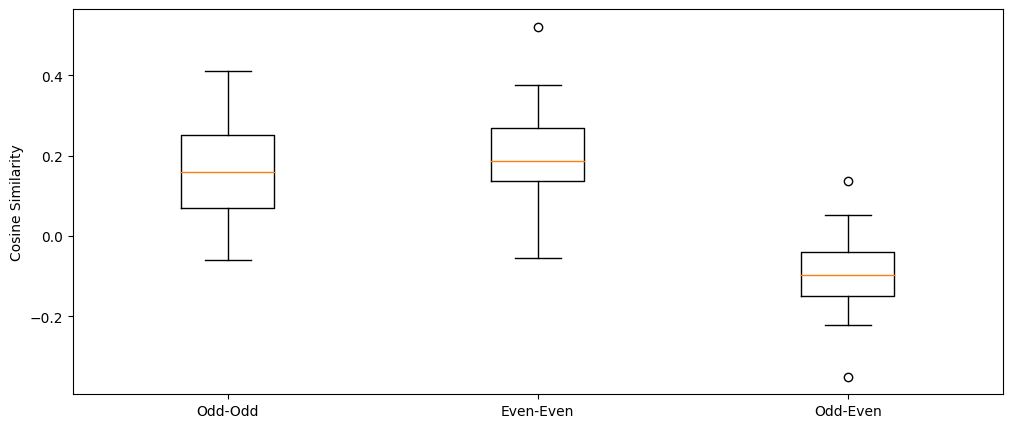

In [97]:
odd_odd_sims = []
even_even_sims = []
odd_even_sims = []

for i in range(n_embeddings):
    for j in range(i+1, n_embeddings):
        sim = cosine_similarity(embeddings[i], embeddings[j])
        if i % 2 == 0 and j % 2 == 0:
            even_even_sims.append(sim)
        elif i % 2 == 1 and j % 2 == 1:
            odd_odd_sims.append(sim)
        else:
            odd_even_sims.append(sim)

print(f"Average odd-odd similarity: {np.mean(odd_odd_sims)}")
print(f"Average even-even similarity: {np.mean(even_even_sims)}")
print(f"Average odd-even similarity: {np.mean(odd_even_sims)}")
#boxplots
plt.figure(figsize=(12, 5))
plt.boxplot([odd_odd_sims, even_even_sims, odd_even_sims], labels=['Odd-Odd', 'Even-Even', 'Odd-Even']);
#yaxis
plt.ylabel('Cosine Similarity');

L2 of each positional embedding:
[0.89619094 0.98506916 0.95845294 0.97425014 1.019482   1.065831
 1.0674049  0.988334   1.4127593  0.8489224 ]


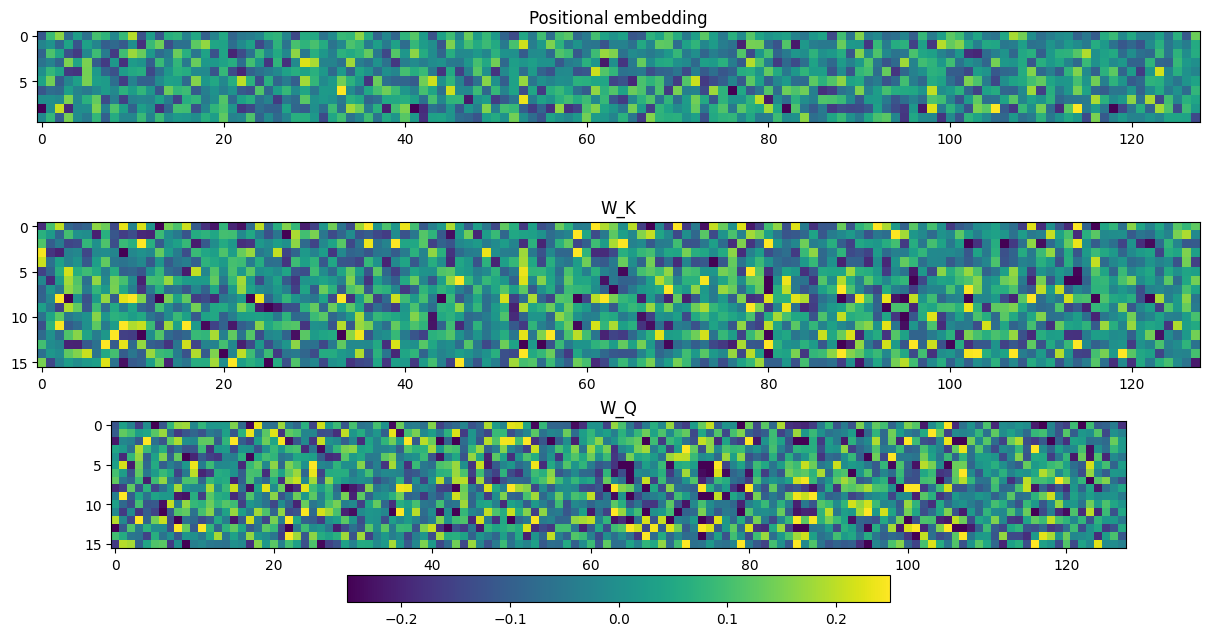

In [98]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
ax[0].imshow(numpy(pos_emb), vmin=vmin, vmax=vmax);
ax[0].set_title("Positional embedding")
ax[1].imshow(numpy(W_K.T), vmin=vmin, vmax=vmax);
ax[1].set_title("W_K")
im = ax[2].imshow(numpy(W_Q.T), vmin=vmin, vmax=vmax);
ax[2].set_title("W_Q")
#horizonal color bar
fig.colorbar(im, ax=ax[2], orientation='horizontal');
#calculate norm of posemb
norm = np.linalg.norm(numpy(pos_emb), axis=1)
print("L2 of each positional embedding:")
print(norm)

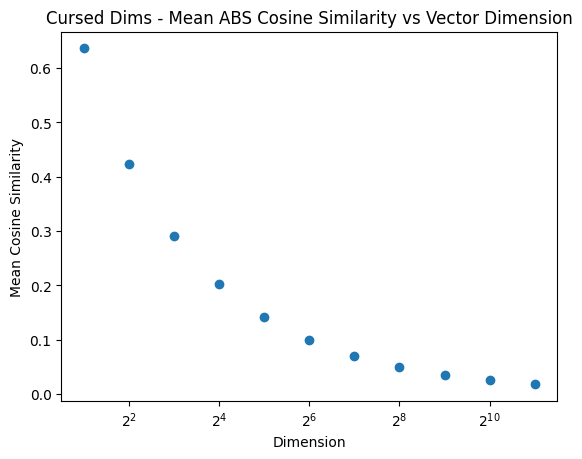

In [99]:
def average_off_diag(array):
    n = array.shape[0]
    return (np.sum(array) - np.trace(array)) / (n*n - n)

dims = [2**n for n in range(1,12)]
results = []
for dim in dims:
    rand_vecs = [np.random.randn(dim) for _ in range(1000)]
        #normed random vectors
    normed_rand_vecs = np.array([vec/np.linalg.norm(vec) for vec in rand_vecs])
    #cosine similarity
    sim = abs(np.dot(normed_rand_vecs, normed_rand_vecs.T))
    #mean of off diagonal elements
    mean_sim = average_off_diag(sim)
    results.append((dim, mean_sim))

plt.plot(*zip(*results), 'o')
plt.xscale('log', base=2)
plt.xlabel('Dimension')
plt.ylabel('Mean Cosine Similarity')
plt.title('Cursed Dims - Mean ABS Cosine Similarity vs Vector Dimension')
plt.show()





TtestResult(statistic=-4.435549500170282, pvalue=2.0124731501429948e-05, df=123.0)

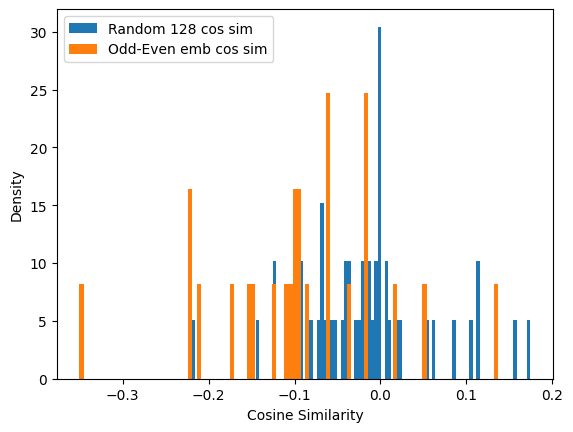

In [100]:
rand_128s = [np.random.randn(128) for _ in range(10)]
normed_rand_128s = np.array([vec/np.linalg.norm(vec) for vec in rand_128s])
sim_128 = np.dot(normed_rand_128s, normed_rand_128s.T)
#remove diagonal
sim_128 = sim_128 - np.diag(np.diag(sim_128))
#histogram of cosine similarities normalized
plt.hist(sim_128.flatten(), bins=100, density=True);
plt.hist(odd_even_sims, bins=100, density=True);
#legend
plt.legend(['Random 128 cos sim', 'Odd-Even emb cos sim'])
#x axis
plt.xlabel('Cosine Similarity')
#y axis
plt.ylabel('Density')

#t test for odd_even_sims and sim_128
from scipy.stats import ttest_ind
ttest_ind(odd_even_sims, sim_128.flatten())


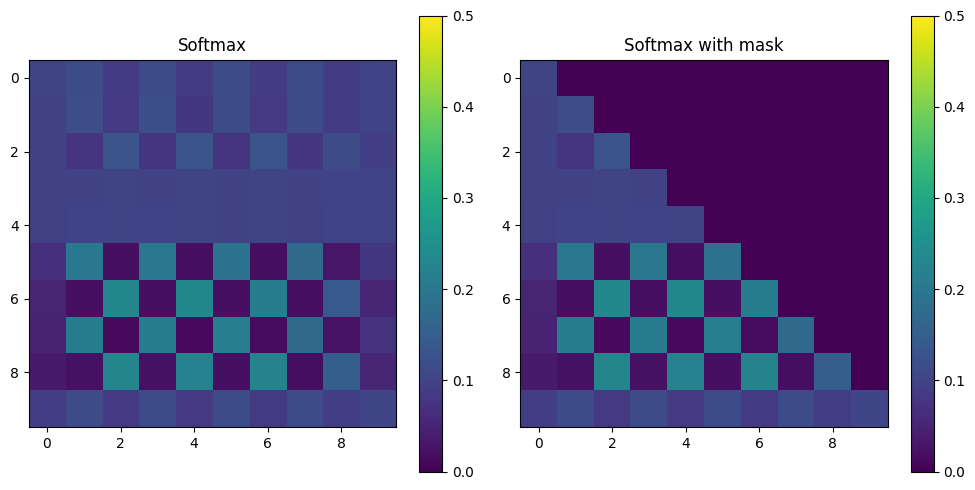

In [101]:
# sub plots
fig, ax = plt.subplots(1,2, figsize=(10,5))
im0 = ax[0].imshow(softmax, vmin=0, vmax=0.5)
ax[0].set_title('Softmax')

im1 = ax[1].imshow(softmax_mask, vmin=0, vmax=0.5)
ax[1].set_title('Softmax with mask')

# Add colorbars
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()

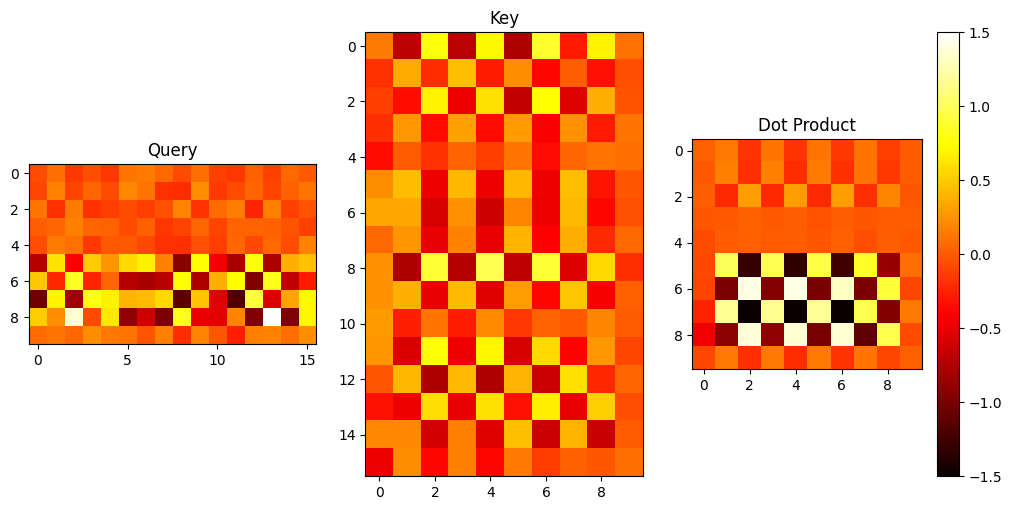

In [102]:
figure, axes = plt.subplots(1,3, figsize=(10,5))
im1 = axes[1].imshow(numpy(K.T), cmap='hot', vmin=-1.5, vmax=1.5)
axes[1].set_title('Key')
im0 = axes[0].imshow(numpy(Q), cmap='hot', vmin=-1.5, vmax=1.5)
axes[0].set_title('Query')
im2 = axes[2].imshow(numpy(dotty), cmap='hot', vmin=-1.5, vmax=1.5)
axes[2].set_title('Dot Product')
plt.tight_layout()
#colorbar
fig.colorbar(im2, ax=axes[2])
plt.show()

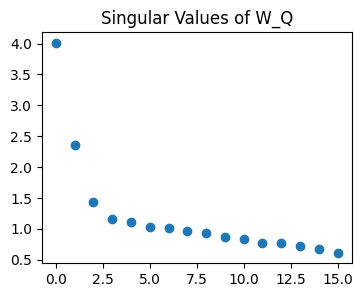

In [103]:
U, S, V = np.linalg.svd(numpy(W_Q))
#plot singular values
plt.figure(figsize=(4,3))
plt.plot(S, 'o');
#title
plt.title('Singular Values of W_Q');

Shape of pos_emb: (10, 128)


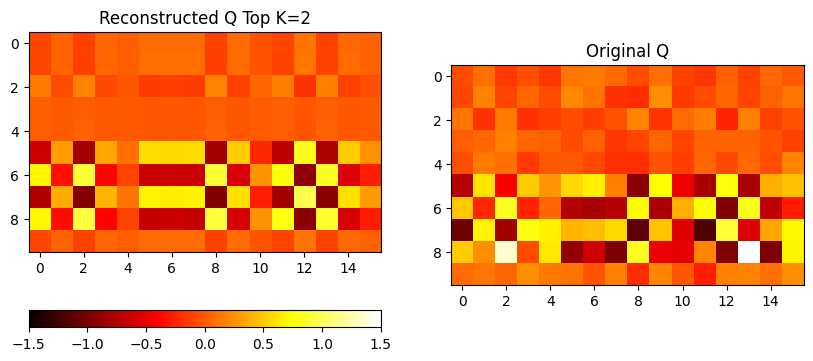

In [104]:
W_Q_recon = U[:,:1] @ np.diag(S[:1]) @ V[:1,:]
Q_recon = numpy(pos_emb) @ W_Q_recon
#pos_emb shape
print("Shape of pos_emb:", numpy(pos_emb).shape)
#plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(Q_recon, cmap="hot", vmin=-1.5, vmax=1.5);
ax[0].set_title('Reconstructed Q Top K=2')
im = ax[1].imshow(numpy(Q), cmap="hot", vmin=-1.5, vmax=1.5);
ax[1].set_title('Original Q')
#colorbar
fig.colorbar(im, ax=ax[0], orientation='horizontal');

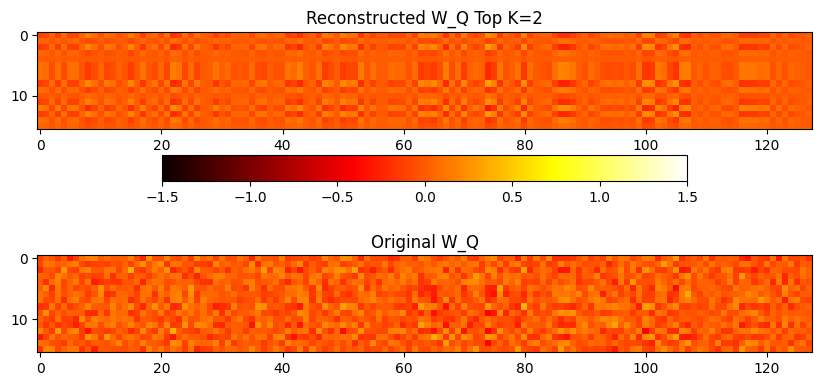

In [105]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
ax[0].imshow(W_Q_recon.T, cmap="hot", vmin=-1.5, vmax=1.5);
ax[0].set_title('Reconstructed W_Q Top K=2')
im = ax[1].imshow(numpy(W_Q.T), cmap="hot", vmin=-1.5, vmax=1.5);
ax[1].set_title('Original W_Q')
#colorbar
fig.colorbar(im, ax=ax[0], orientation='horizontal');

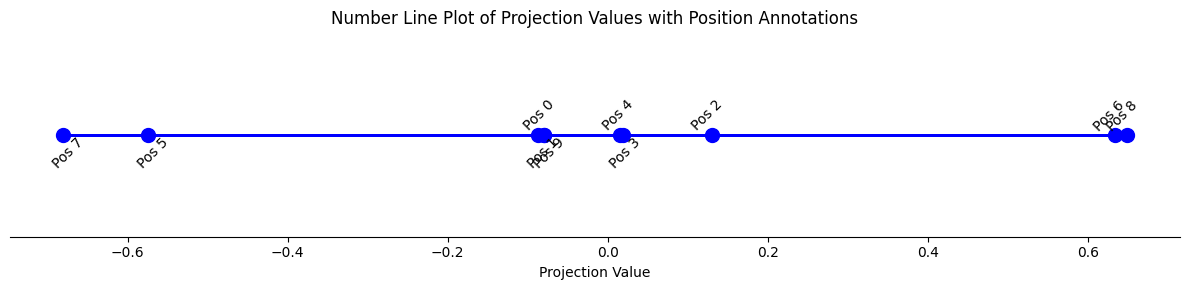

In [106]:
#projection of posemd onto U of W_Q
Q_proj = numpy(pos_emb) @ U[:,:1]
#turn to list
Q_proj = Q_proj.tolist()
#list of just numbers rather than list of lists
Q_proj = [x[0] for x in Q_proj]
#zip with range 0-9
Q_proj = list(zip(range(10), Q_proj))

# Unzip the list of tuples
positions, values = zip(*Q_proj)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 3))

# Plot the number line
ax.plot(values, [0]*len(values), 'b-', linewidth=2)

# Plot the points
ax.plot(values, [0]*len(values), 'bo', markersize=10)

# Add annotations, alternating above and below
for i, (pos, val) in enumerate(Q_proj):
    if i % 2 == 0:
        y_pos = 10
        va = 'bottom'
    else:
        y_pos = -10
        va = 'top'
    
    ax.annotate(f'Pos {pos}', (val, 0), xytext=(0, y_pos), 
                textcoords='offset points', ha='center', va=va,
                rotation=45, rotation_mode='anchor')

# Remove y-axis and spines
ax.yaxis.set_visible(False)
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

# Set x-axis label and title
ax.set_xlabel('Projection Value')
ax.set_title('Number Line Plot of Projection Values with Position Annotations')

# Adjust layout and display
plt.tight_layout()
plt.show()


<BarContainer object of 128 artists>

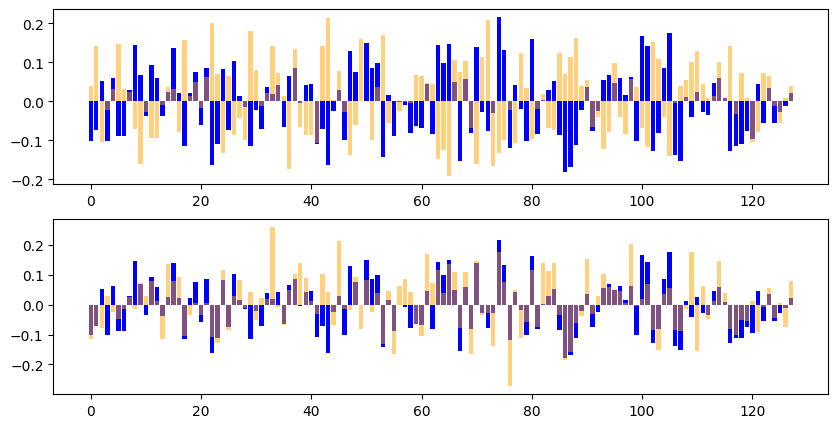

In [107]:
#bar plot U[:, :1]
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].bar(range(128), U[:, 0], color='blue')
#add bar plot for pos_emb
axes[0].bar(range(128), numpy(pos_emb)[5], color='orange', alpha=0.5)

axes[1].bar(range(128), U[:, 0], color='blue')
axes[1].bar(range(128), numpy(pos_emb)[6], color='orange', alpha=0.5)

In [108]:
# look at high magnitude position 8, how does it propagate through the network
# how do other positional embeddings perform
# How do smaller networks and smaller embeds/dmodels perform and represent things